# Installing YOLOv7

In [1]:
! git clone https://github.com/WongKinYiu/yolov7.git

'yolov7'에 복제합니다...
remote: Enumerating objects: 1094, done.
remote: Total 1094 (delta 0), reused 0 (delta 0), pack-reused 1094
오브젝트를 받는 중: 100% (1094/1094), 69.89 MiB | 14.21 MiB/s, 완료.
델타를 알아내는 중: 100% (517/517), 완료.


In [17]:
%cd yolov7
!ls

[Errno 2] No such file or directory: 'yolov7'
/Users/werther/yolov7
4124287451827527828img_5023-1_keypoint.mp4
4124287451827527828img_5023-2_keypoint.mp4
4124287451827527828img_5023-3_keypoint.mp4
4124287451827527828img_5023-4_keypoint.mp4
4124287451827527828img_5023-5_keypoint.mp4
4124287451827527828img_5023-6_keypoint.mp4
4124287451827527828img_5023-7_keypoint.mp4
4124287451827527828img_5023-8_keypoint.mp4
4124287451827527828img_5023-9_keypoint.mp4
4124287451827527828img_5023_keypoint.mp4
LICENSE.md
README.md
cfg
dasol_pose_side_v_keypoint.mp4
data
deploy
detect.py
export.py
figure
hubconf.py
inference
models
paper
requirements.txt
scripts
test.py
tools
train.py
train_aux.py
utils
yolov7-w6-pose.pt


In [18]:
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt -o yolov7-w6-pose.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  153M  100  153M    0     0  9203k      0  0:00:17  0:00:17 --:--:-- 8616kk      0  0:00:17  0:00:16  0:00:01 8793k


# Loading the YOLOv7 Pose Estimation Model

torch and torchvision are straightforward enough - YOLOv7 is implemented with PyTorch. The utils.datasets, utils.general and utils.plots modules come from the YOLOv7 project, and provide us with methods that help with preprocessing and preparing input for the model to run inference on. Amongst those are letterbox() to pad the image, non_max_supression_keypoint() to run the Non-Max Supression algorithm on the initial output of the model and to produce a clean output for our interpretation, as well as the output_to_keypoint() and plot_skeleton_kpts() methods to actually add keypoints to a given image, once they're predicted.

We can load the model from the weight file with torch.load(). Let's create a function to check if a GPU is available, load the model, put it in inference mode and move it to the GPU if available:

In [19]:
!install python3-tk

usage: install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 file2
       install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 ... fileN directory
       install -d [-v] [-g group] [-m mode] [-o owner] directory ...


In [20]:
import torch
from torchvision import transforms

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

import cv2
import numpy as np
import os

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

We can load the model from the weight file with torch.load(). Let's create a function to check if a GPU is available, load the model, put it in inference mode and move it to the GPU if available:

In [22]:
def load_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('/Users/werther/yolov7/yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model

model = load_model()

With the model loaded, let's create a run_inference() method that accepts a string pointing to a file on our system. The method will read the image using OpenCV (cv2), pad it with letterbox(), apply transforms to it, and turn it into a batch (the model is trained on and expects batches, as usual):

In [23]:
def run_inference(url):
    image = cv2.imread(url) # shape: (480, 640, 3)
    # Resize and pad image
    image = letterbox(image, 960, stride=64, auto=True)[0] # shape: (768, 960, 3)
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 768, 960])
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 768, 960])
    output, _ = model(image) # torch.Size([1, 45900, 57])
    return output, image

Here, we've returned the transformed image (because we'll want to extract the original and plot on it) and the outputs of the model. These outputs contain 45900 keypoint predictions, most of which overlap. We'll want to apply Non-Max Supression to these raw predictions, just as with Object Detection predictions (where many bounding boxes are predicted and then they're "collapsed" given some confidence and IoU threshold). After supression, we can plot each keypoint on the original image and display it:

In [27]:
def plot_skeleton_kpts(im, kpts, steps, reps=1, num=1, orig_shape=None):
    print("plot_skeleton_kpts start")

    li1 = []
    lst_coordinate = []
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    radius = 5
    num_kpts = len(kpts) // steps


    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[steps * kid], kpts[steps * kid + 1]
        if not (x_coord % 640 == 0 or y_coord % 640 == 0):
            if steps == 3:
                conf = kpts[steps * kid + 2]
                if conf < 0.5:
                    print("plot_skeleton_kpts CONTINUE")
                    continue
            cv2.circle(im, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)
            
            # (추가) 각 포인트마다 좌표를 이미지에 출력한다.
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = f'({int(x_coord)}, {int(y_coord)})'
            cv2.putText(im, text, (int(x_coord), int(y_coord)), font, 0.5, (int(r), int(g), int(b)), 2)
            
            
            # (추가) 포인트 좌표를 리스트에 추가, 
            lst_coordinate.append((int(x_coord), int(y_coord)))
    
    # (추가) 포인트의 개수가 17개보다 적을 경우(얼굴이 잘려 있는 영상의 경우, 포인트의 개수가 적다) : 결측치로 채우기
    if len(lst_coordinate) < 17:
        lst_nan = []
        for i in range(17 - len(lst_coordinate)):
            lst_nan.append(np.nan)
        lst_coordinate = lst_nan + lst_coordinate
        
    # (추가) 좌표 리스트를 딕셔너리에 추가
    dict_coordinate[f'img_{reps}_{num}'] = lst_coordinate
    print("plot_skeleton_kpts END!")

    

def visualize_output(output, image):
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
        
        
        
    cv2.imshow('lena color', nimg)            
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(nimg)
    plt.show()

Now, for some input image, such as karate.jpg in the main working directory, we can run inference, perform Non-Max Supression and plot the results with:

plot_skeleton_kpts start
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts END!


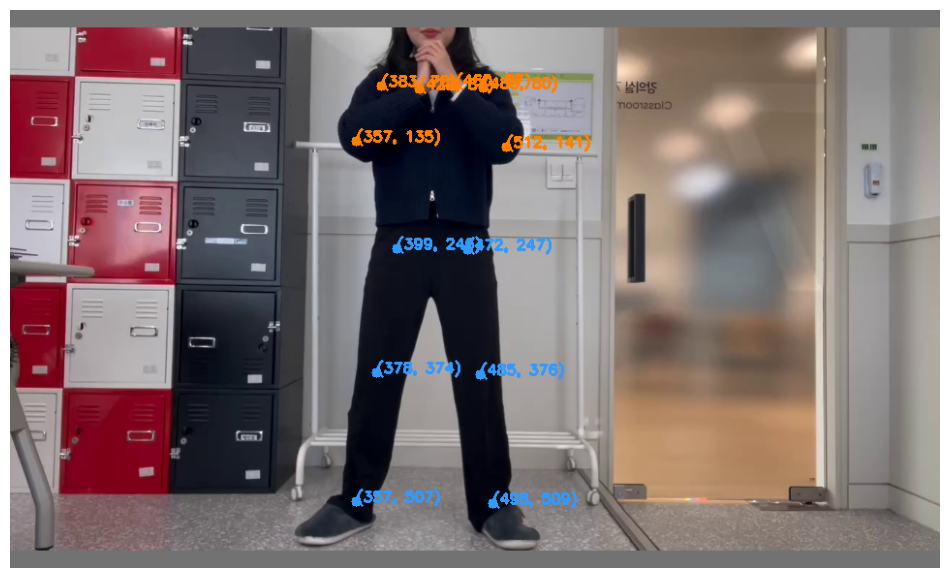

In [28]:
output, image = run_inference('/Users/werther/dasol_squat_img/dasol_squat_img/no1/img_1_1.jpg') # Bryan Reyes on Unsplash

visualize_output(output, image)

# YOLOv7 Pose Code
We will need a custom script to run pose estimation inference using the pre-trained model. Let’s write the code in a new yolov7_keypoint.py script inside the yolov7 directory.

In [31]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import time
 
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

def load_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load('/Users/werther/yolov7/yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model

model = load_model()

# model = model.half().to(device)
# _ = model.eval()
 
video_path = '/Users/werther/super_squat.mov'

We import all the required modules and load the pre-trained yolov7-w6-pose.pt model, and initialize a video_path variable for the path to the source video. If you intend to run this inference on your own videos, please change the video_path accordingly.

Next, let’s read the video from the disk and create the VideoWriter object to save the resulting video on the disk.

In [32]:
cap = cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# Get the frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Pass the first frame through `letterbox` function to get the resized image,
# to be used for `VideoWriter` dimensions. Resize by larger side.
vid_write_image = letterbox(cap.read()[1], (frame_width), stride=64, auto=True)[0]
resize_height, resize_width = vid_write_image.shape[:2]

save_name = f"{video_path.split('/')[-1].split('.')[0]}"
# Define codec and create VideoWriter object .
out = cv2.VideoWriter(f"{save_name}_keypoint.mp4",
                    cv2.VideoWriter_fourcc(*'mp4v'), 30,
                    (resize_width, resize_height))


frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

Finally, we have a while loop running through each frame in the video.

In [33]:
def step_3(cap, out, reps) :
    num = 1
    print("step3 start")
    while(cap.isOpened):
        print('while in step3')
        # Capture each frame of the video.
        ret, frame = cap.read()
        if (int(cap.get(1)) % 0.5 == 0):
            print('if in while')
            orig_image = frame

            image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
            image2 = image.copy()
            image = letterbox(image, 960, stride=64, auto=True)[0] # shape: (768, 960, 3)
    #         image = letterbox(image, (frame_width), stride=64, auto=True)[0]
            # Apply transforms
            image = transforms.ToTensor()(image) # torch.Size([3, 768, 960])
            # Turn image into batch
            image = image.unsqueeze(0) # torch.Size([1, 3, 768, 960])
            
            with torch.no_grad():
                output, _ = model(image)

            
            # IMG 파일 저장
            # save_file = 저장경로, nimg = 저장할 이미지
            plt.imshow(orig_image)
            path = f"/Users/werther/dasol_train/img/img_{reps}_{num}.jpg"
            print("inwrite start")
            cv2.imwrite(path, orig_image)
            print('Saved frame number :', str(int(cap.get(1))))
            
            
            output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
            output = output_to_keypoint(output)
            nimg = image[0].permute(1, 2, 0) * 255
            nimg = nimg.cpu().numpy().astype(np.uint8)
            nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
            for idx in range(output.shape[0]):
                print('plot_skeleton_kpts ready')
                plot_skeleton_kpts(nimg, output[idx, 7:].T, 3, reps=reps, num=num)

            num += 1
        else :
            print(f"step3 break / {num}")
            break

            


In [39]:
def plot_skeleton_kpts(im, kpts, steps, reps, num, orig_shape=None):
    print("plot_skeleton_kpts start")

    li1 = []
    lst_coordinate = []
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    radius = 5
    num_kpts = len(kpts) // steps


    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[steps * kid], kpts[steps * kid + 1]
        if not (x_coord % 640 == 0 or y_coord % 640 == 0):
            if steps == 3:
                conf = kpts[steps * kid + 2]
                if conf < 0.5:
                    print("plot_skeleton_kpts CONTINUE")
                    continue
            cv2.circle(im, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)
            
            # (추가) 각 포인트마다 좌표를 이미지에 출력한다.
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = f'({int(x_coord)}, {int(y_coord)})'
            cv2.putText(im, text, (int(x_coord), int(y_coord)), font, 0.5, (int(r), int(g), int(b)), 2)
            
            
            # (추가) 포인트 좌표를 리스트에 추가, 
            lst_coordinate.append((int(x_coord), int(y_coord)))
    
    # (추가) 포인트의 개수가 17개보다 적을 경우(얼굴이 잘려 있는 영상의 경우, 포인트의 개수가 적다) : 결측치로 채우기
    if len(lst_coordinate) < 17:
        lst_nan = []
        for i in range(17 - len(lst_coordinate)):
            lst_nan.append(np.nan)
        lst_coordinate = lst_nan + lst_coordinate
        
    # (추가) 좌표 리스트를 딕셔너리에 추가
    dict_coordinate[f'img_{reps}_{num}'] = lst_coordinate
    print("plot_skeleton_kpts END!")

    

super_squat.mov
just for reps : 1
step3 start
while in step3
if in while
inwrite start
Saved frame number : 2
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 3
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 4
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts CONTINUE
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 5
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_s

inwrite start
Saved frame number : 52
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 53
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 54
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 55
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 56
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 57
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame number : 58
plot_skeleton_kpts ready
plot_skeleton_kpts start
plot_skeleton_kpts END!
while in step3
if in while
inwrite start
Saved frame n

KeyboardInterrupt: 

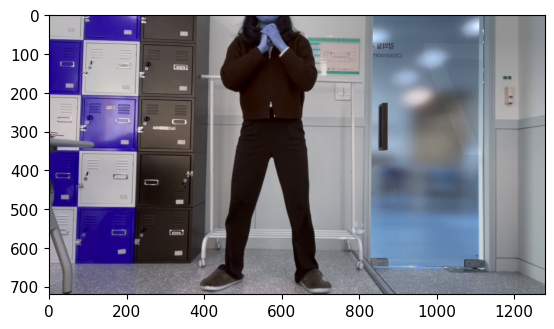

In [40]:
path = '/Users/werther/samplevideo/'

lst_all = maekFrame(path) #전체 이미지 프레임

dasol_train = os.listdir(path)

dict_coordinate = {}
num1 = 1 # 랩스 넘버링
num = 1 # 이미지(=프레임) 넘버링
reps = 1

for d_t in dasol_train :

    # step.1
    model = load_model()
    video_path = f"/Users/werther/samplevideo/{d_t}"
    
    # step.2
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened() == False):
        print('Error while trying to read video. Please check path again')



    # Get the frame width and height.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # Pass the first frame through `letterbox` function to get the resized image,
    # to be used for `VideoWriter` dimensions. Resize by larger side.
    vid_write_image = letterbox(cap.read()[1], (frame_width), stride=64, auto=True)[0] # Padding
    resize_height, resize_width = vid_write_image.shape[:2]

    save_name = f"{video_path.split('/')[-1].split('.')[0]}"
    # Define codec and create VideoWriter object .
    out = cv2.VideoWriter(f"{save_name}_keypoint.mp4",
                        cv2.VideoWriter_fourcc(*'mp4v'), 30,
                        (resize_width, resize_height))

    
    # step.3
    # + 1장의 이미지의 좌표 임의의 csv에 저장 -> plot_skeleton_kpts에서 수정.
    print(f'just for reps : {reps}')
    step_3(cap, out, reps)

    reps += 1

    # + 30장의 사진을 임의의 폴더에 저장

    
#csv을 저장


# 결론
# 300개의 IMG파일
# 1개의 CSV파일
    

In [41]:
dict_coordinate

{'img_1_1': [nan,
  nan,
  nan,
  nan,
  nan,
  (488, 80),
  (383, 79),
  (513, 141),
  (358, 135),
  (462, 78),
  (422, 81),
  (471, 246),
  (399, 246),
  (486, 374),
  (377, 373),
  (499, 508),
  (357, 507)],
 'img_1_2': [nan,
  nan,
  nan,
  nan,
  nan,
  (488, 80),
  (383, 79),
  (513, 141),
  (358, 135),
  (462, 78),
  (423, 81),
  (472, 245),
  (399, 245),
  (487, 375),
  (376, 374),
  (499, 509),
  (357, 507)],
 'img_1_3': [nan,
  nan,
  nan,
  nan,
  nan,
  (488, 80),
  (383, 79),
  (512, 143),
  (358, 136),
  (462, 79),
  (424, 82),
  (472, 247),
  (399, 246),
  (489, 373),
  (375, 371),
  (499, 508),
  (356, 506)],
 'img_1_4': [nan,
  nan,
  nan,
  nan,
  nan,
  (488, 81),
  (383, 80),
  (512, 144),
  (358, 137),
  (463, 80),
  (424, 83),
  (472, 249),
  (399, 248),
  (491, 375),
  (373, 370),
  (500, 509),
  (356, 506)],
 'img_1_5': [nan,
  nan,
  nan,
  nan,
  nan,
  (489, 82),
  (383, 81),
  (512, 146),
  (359, 139),
  (463, 82),
  (424, 84),
  (473, 252),
  (399, 251),
  

In [ ]:
import numpy as np

def makeImg(lst_all) : 
    for no in range(len(lst_all)):
        directory = '/Users/werther/samplevideo/dasol_squat_img/' # 추출할 이미지들을 저장할 경로
        make_dir = os.mkdir(f'/Users/werther/samplevideo/dasol_squat_img/no{no+1}') # 각 랩스별 폴더 생성
        temp_dir = f'no{no+1}/'

        count_frame = len(lst_all[no])

        img_count = 30 # 각 랩스 당 추출하고 싶은 이미지 개수 (= 30개)
        skip = count_frame / img_count

        print(no, count_frame, skip)
        babo = 0 # 이미지 넘버링

        for cnt in range(len(lst_all[no])):
            if cnt == np.floor(skip * babo):
                babo += 1
                path = directory + temp_dir + f'img_{no+1}_' + str(babo) + '.jpg' # 해당 경로에 추출한 이미지를 저장.
                frame = lst_all[no][cnt]
    #             print(f'babo = {babo}')
                
                cv2.imwrite(path, frame)
                

In [42]:
def maekFrame(path) : 
    PATH = path # 저장된 동영상 경로
    lst_all = [] # 전체 영상 이미지들을 저장할 리스트 (10랩스 * 30장)
    lst = [] # 1랩스의 이미지들을 저장할 리스트 (30장)

    for no, p in enumerate(os.listdir(PATH)):
        video = cv2.VideoCapture(PATH + p)
        count_frame = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # 영상의 프레임 개수 (= 추출 가능한 최대 이미지 개수)
        fps = video.get(cv2.CAP_PROP_FPS)

        count = 0 # 이미지 넘버링
        while(video.isOpened()):
            ret, frame = video.read() 
            if not ret:
                print(ret, count)
                break

            if ret:
                lst.append(frame)
                count += 1

        lst_all.append(lst)
        lst = []

        video.release()
    return lst_all

In [138]:
df = pd.DataFrame(dict_coordinate)
df2 = df.T
df2

df2.to_csv('/Users/werther/no1_images.csv')

NameError: name 'pd' is not defined

In [28]:
vidcap = cv2.VideoCapture('/Users/werther/dasol_train/iCloud_사진/4124287451827527828img_5023-8.mov')

count = 0

#불러온 비디오 파일의 정보 출력
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = vidcap.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 113
width : 1280
height : 720
fps : 27.076677316293928


In [21]:
count = 0


while(vidcap.isOpened()):
    ret, image = vidcap.read()
    if(int(vidcap.get(1)) % 0.5 == 0): #앞서 불러온 fps 값을 사용하여 1초마다 추출
        cv2.imwrite("/Users/werther/dasol_train" + "/frame%d.jpg" % count, image)
        print('Saved frame number :', str(int(vidcap.get(1))))
        count += 1
        
vidcap.release()

Saved frame number : 1
Saved frame number : 2
Saved frame number : 3
Saved frame number : 4
Saved frame number : 5
Saved frame number : 6
Saved frame number : 7
Saved frame number : 8
Saved frame number : 9
Saved frame number : 10
Saved frame number : 11
Saved frame number : 12
Saved frame number : 13
Saved frame number : 14
Saved frame number : 15
Saved frame number : 16
Saved frame number : 17
Saved frame number : 18
Saved frame number : 19
Saved frame number : 20
Saved frame number : 21
Saved frame number : 22
Saved frame number : 23
Saved frame number : 24
Saved frame number : 25
Saved frame number : 26
Saved frame number : 27
Saved frame number : 28
Saved frame number : 29
Saved frame number : 30
Saved frame number : 31
Saved frame number : 32
Saved frame number : 33
Saved frame number : 34
Saved frame number : 35
Saved frame number : 36
Saved frame number : 37
Saved frame number : 38
Saved frame number : 39
Saved frame number : 40
Saved frame number : 41
Saved frame number : 42
S

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [ ]:
for no, p in enumerate(os.listdir(PATH)):
#     if no > 0:
#         break
    video = cv2.VideoCapture(PATH + p)
    count_frame = video.get(cv2.CAP_PROP_FRAME_COUNT)
    temp_dir = f'no{no+1}/'
    skip = int(count_frame / 30)
    print(count_frame, temp_dir, skip)
    num = 1
    count = 0
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        if ret and (count % (skip + 1) == 0):
            print('hiu')
#             plt.im show(frame)
            # 이미지 저장 위치, 이미지의 각 이름을 자동으로 지정
            path = directory + temp_dir + f'img_{no+1}_' + str(num) + '.jpg'
            cv2.imwrite(path, frame) # 영상 -> 이미지로 저장
            num += 1
        count += 1
    video.release()

In [ ]:
path = '/Users/werther/samplevideo/'

lst_all = maekFrame(path) #전체 이미지 프레임

dasol_train = os.listdir(path)

dict_coordinate = {}
num1 = 1 # 랩스 넘버링
num = 1 # 이미지(=프레임) 넘버링
reps = 1

for d_t in dasol_train :

    # step.1
    model = load_model()
    video_path = f"/Users/werther/samplevideo/{d_t}"
    
    # step.2
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened() == False):
        print('Error while trying to read video. Please check path again')

    # Get the frame width and height.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # Pass the first frame through `letterbox` function to get the resized image,
    # to be used for `VideoWriter` dimensions. Resize by larger side.
    vid_write_image = letterbox(cap.read()[1], (frame_width), stride=64, auto=True)[0]
    resize_height, resize_width = vid_write_image.shape[:2]

    save_name = f"{video_path.split('/')[-1].split('.')[0]}"
    # Define codec and create VideoWriter object .
    out = cv2.VideoWriter(f"{save_name}_keypoint.mp4",
                        cv2.VideoWriter_fourcc(*'mp4v'), 30,
                        (resize_width, resize_height))

    
    # step.3
    # + 1장의 이미지의 좌표 임의의 csv에 저장 -> plot_skeleton_kpts에서 수정.
    print(f'just for reps : {reps}')
    step_3(cap, out, reps)

    reps += 1

    # + 30장의 사진을 임의의 폴더에 저장

    
#csv을 저장


# 결론
# 300개의 IMG파일
# 1개의 CSV파일
    